<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/06_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [3]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [4]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

100%|██████████| 9912422/9912422 [00:00<00:00, 150931388.63it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35083430.46it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



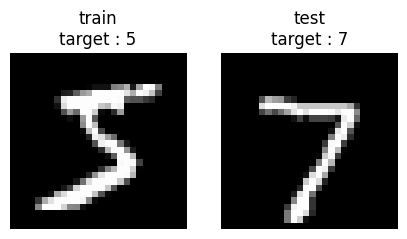

In [5]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [6]:
data_dim = 28*28

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [7]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1113.4815673828125
Epoch :  2   -----------> Loss :  1064.8915710449219
Epoch :  3   -----------> Loss :  1017.3412322998047
Epoch :  4   -----------> Loss :  970.4309285481771
Epoch :  5   -----------> Loss :  924.1978251139323
Epoch :  6   -----------> Loss :  878.1625264485677
Epoch :  7   -----------> Loss :  832.5345001220703
Epoch :  8   -----------> Loss :  787.2181955973307
Epoch :  9   -----------> Loss :  742.1661732991537
Epoch :  10   -----------> Loss :  697.1728668212891
Epoch :  11   -----------> Loss :  652.3182932535807
Epoch :  12   -----------> Loss :  607.2764689127604
Epoch :  13   -----------> Loss :  563.7929840087891
Epoch :  14   -----------> Loss :  519.5525716145834
Epoch :  15   -----------> Loss :  475.69591013590497
Epoch :  16   -----------> Loss :  432.61280314127606
Epoch :  17   -----------> Loss :  389.12999725341797
Epoch :  18   -----------> Loss :  347.75760142008465
Epoch :  19   -----------> Loss :  306.270477294

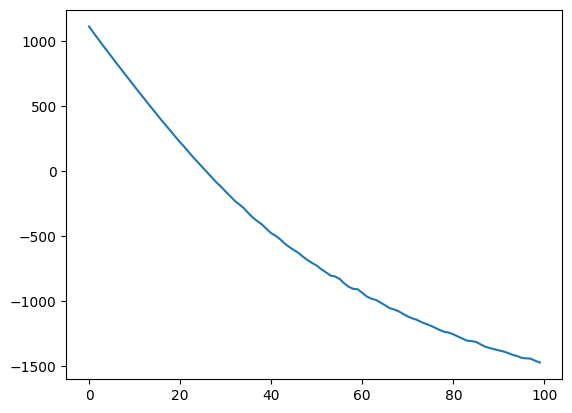

In [8]:
plt.plot(COST)

In [9]:
test = prior.sample((50,))
test

tensor([[ 0.4081,  1.1556,  0.6845,  ...,  0.3168,  1.2060,  0.4393],
        [ 0.1038, -0.8215,  1.6755,  ...,  0.5424,  0.0405, -1.7886],
        [ 0.4220, -0.2474,  0.8706,  ...,  0.4473,  1.3133,  1.1503],
        ...,
        [-0.1154, -0.6239, -1.8092,  ..., -0.9756, -0.2938,  1.8123],
        [-2.2223,  0.0234,  0.5622,  ...,  1.5908, -0.2370, -0.3754],
        [-0.7813, -1.1515, -0.5412,  ...,  1.1804,  1.3194,  0.7429]])

In [10]:
sonuc = model.f_inv(test)
sonuc

tensor([[-0.0026,  0.0033,  0.0014,  ...,  0.0014, -0.0080,  0.0028],
        [-0.0024, -0.0042,  0.0005,  ...,  0.0005, -0.0052,  0.0004],
        [-0.0068,  0.0010,  0.0015,  ...,  0.0158, -0.0046,  0.0066],
        ...,
        [-0.0018,  0.0021,  0.0033,  ...,  0.0076, -0.0047,  0.0003],
        [ 0.0011, -0.0005, -0.0040,  ..., -0.0032, -0.0048,  0.0032],
        [-0.0046,  0.0015, -0.0064,  ..., -0.0006,  0.0040, -0.0042]],
       grad_fn=<MulBackward0>)

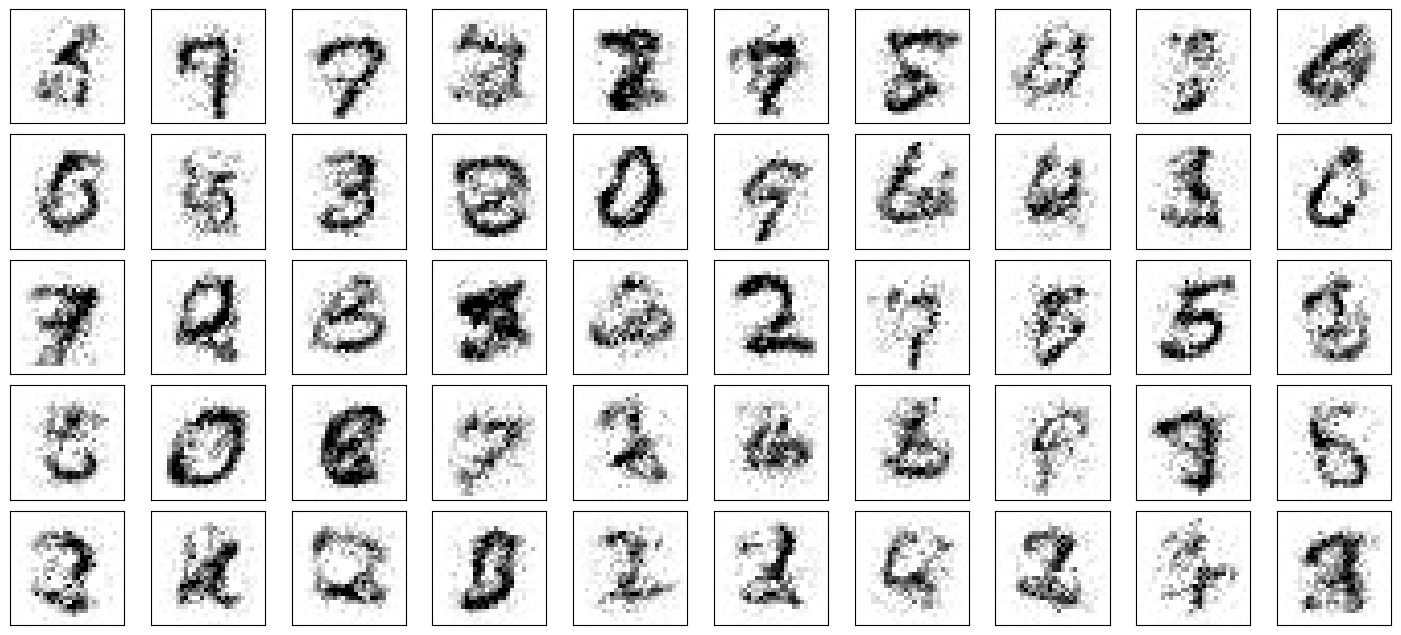

In [11]:
test = prior.sample((50,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))

fig.show()